In [1]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from scipy.linalg import expm

In [2]:
def Phi(A,T,G):
    
    return -(1/2)*1j*np.log((-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2)))

def A12(A,T,G):
    
    return (1/2)*1j*(np.log((A*(1/np.sinh(T/2))-(1j+2*A*(1/np.sinh(T))*np.sinh(G/2))*np.sqrt(-1+((1)/(0.5-1j*A*(1/np.sinh(T))*np.sinh(G/2)))))/(np.sqrt(1+2*A**(2)*(np.cosh(G)+np.cosh(T))*(1/np.sinh(T))**(2))))-np.log((A*(1/np.sinh(T/2))+(1j+2*A*(1/np.sinh(T))*np.sinh(G/2))*np.sqrt(-1+((1)/(0.5-1j*A*(1/np.sinh(T))*np.sinh(G/2)))))/(np.sqrt(1+2*A**(2)*(np.cosh(G)+np.cosh(T))*(1/np.sinh(T))**2))))

def A11(A,T,G):
    return -np.arccos((2*A*np.cosh(G/2)*(1/np.sinh(T)))/(np.sqrt(1+2*A**(2)*(np.cosh(G)+np.cosh(T))*(1/np.sinh(T))**(2))))/(np.sqrt(1+A**(2)*(1/np.cosh(T/2)**(2))))

def B12(A,T,G):
    return (-1j*A*np.arccos((2*A*np.cosh(G/2)*(1/np.sinh(T)))/(np.sqrt(1+2*A**(2)*(np.cosh(G)+np.cosh(T))*(1/np.sinh(T))**(2))))*(1/np.cosh(T/2)))/(np.sqrt(1+A**(2)*(1/np.cosh(T/2)**(2))))




def H(k,A,T,G,t):
    
    H=np.zeros((4,4),dtype=complex)
            
    phi = Phi(A,T,G)
    a11 = A11(A,T,G)
    a12 = t*A12(A,T,G)
    b12 = B12(A,T,G)
            
    H[0,0]=-a11+a12*np.cos(k-phi)
    H[0,1]=-1j*a12*np.sin(k-phi)
    H[0,2]=b12*np.cos(k)
    H[0,3]=1j*b12*np.sin(k)
    
    H[1,0]=1j*a12*np.sin(k-phi)
    H[1,1]=-a11-a12*np.cos(k-phi)
    H[1,2]=1j*b12*np.sin(k)
    H[1,3]=b12*np.cos(k)    

    H[2,0]=-b12*np.cos(k)
    H[2,1]=1j*b12*np.sin(k)
    H[2,2]=a11+a12*np.cos(k+phi)
    H[2,3]=1j*a12*np.sin(k+phi)
    
    H[3,0]=1j*b12*np.sin(k)
    H[3,1]=-b12*np.cos(k)    
    H[3,2]=-1j*a12*np.sin(k+phi)
    H[3,3]=a11-a12*np.cos(k+phi)
    
    return(H)
    
def Hprime(k,A,T,G,t):
    
    H=np.zeros((4,4),dtype=complex)
    
    phi = Phi(A,T,G)
    a11 = A11(A,T,G)
    a12 = t*A12(A,T,G)
    b12 = B12(A,T,G)
    
    H[0,0]=-a11+a12*np.cos(k-phi)
    H[0,1]=1j*a12*np.sin(k-phi)
    H[0,2]=-b12*np.cos(k)
    H[0,3]=1j*b12*np.sin(k)
    
    H[1,0]=-1j*a12*np.sin(k-phi)
    H[1,1]=-a11-a12*np.cos(k-phi)
    H[1,2]=1j*b12*np.sin(k)
    H[1,3]=-b12*np.cos(k)    

    H[2,0]=b12*np.cos(k)
    H[2,1]=1j*b12*np.sin(k)
    H[2,2]=a11+a12*np.cos(k+phi)
    H[2,3]=-1j*a12*np.sin(k+phi)
    
    H[3,0]=1j*b12*np.sin(k)
    H[3,1]=b12*np.cos(k)    
    H[3,2]=1j*a12*np.sin(k+phi)
    H[3,3]=a11-a12*np.cos(k+phi)
    
    return(H)    
    
def Uf(k,A,T,G,t):
    return expm(1j*Hprime(k,A,T,G,t))@expm(1j*H(k,A,T,G,t))

In [3]:
#Phi(1,2,1) #correct 
#B12(1,2,1) #correct 
#A12(1,2,1) #correct 
#A11(1,2,1) #correct 

In [4]:
#numerical check of Uf A=1 T=2 G=1 k=1

Uf(1,1,2,1,1)

array([[-0.77357083+0.03748843j, -0.40898414-0.36036794j,
        -0.31669714+0.01341273j,  0.03780373+0.03381722j],
       [-0.40898414-0.36036794j,  0.2407261 +0.4069908j ,
         0.20880833+0.64832153j,  0.07787154-0.09638806j],
       [-0.31669714+0.01341273j,  0.20880833+0.64832153j,
        -0.26926142-0.5446701j , -0.22673019+0.12258666j],
       [ 0.03780373+0.03381722j,  0.07787154-0.09638806j,
        -0.22673019+0.12258666j, -0.65638549-0.69627341j]])

In [61]:
A,G,T=1,1,1.3
t=0.9
delta=0.001
k_range=np.arange(0.007,np.pi/2-0.005,0.005)
k_range1=np.arange(-0.007,-np.pi/2+0.005,-0.005)
lista1=np.zeros((len(k_range),4),dtype=complex)
lista2=np.zeros((len(k_range),4),dtype=complex)
lista3=np.zeros((len(k_range1),4),dtype=complex)
lista4=np.zeros((len(k_range1),4),dtype=complex)
for i,k in tqdm(enumerate(k_range)):
    #print(i,k)
    eigvals1,_=np.linalg.eig(np.exp(np.pi*1j/1000)*Uf(k,A,T,G,t))
    eigvals2,_=np.linalg.eig(np.exp(-np.pi*1j/1000)*Uf(k,A,T,G,t))
    order1 = np.argsort(eigvals1)
    order2 = np.argsort(eigvals2)
    eigvals1 = eigvals1[order1]
    eigvals2 = eigvals2[order2]
    args1 = np.angle(eigvals1)
    args2 = np.angle(eigvals2)
    
    lista1[i]=args1
    lista2[i]=args2
                
for i,k in tqdm(enumerate(k_range1)):
    #print(i,k)
    eigvals1,_=np.linalg.eig(np.exp(np.pi*1j/1000)*Uf(k,A,T,G,t))
    eigvals2,_=np.linalg.eig(np.exp(-np.pi*1j/1000)*Uf(k,A,T,G,t))
    order1 = np.argsort(eigvals1)
    order2 = np.argsort(eigvals2)
    eigvals1 = eigvals1[order1]
    eigvals2 = eigvals2[order2]
    args1 = np.angle(eigvals1)
    args2 = np.angle(eigvals2)
    
    lista3[i]=args1
    lista4[i]=args2

312it [00:00, 2442.50it/s]
312it [00:00, 2755.80it/s]


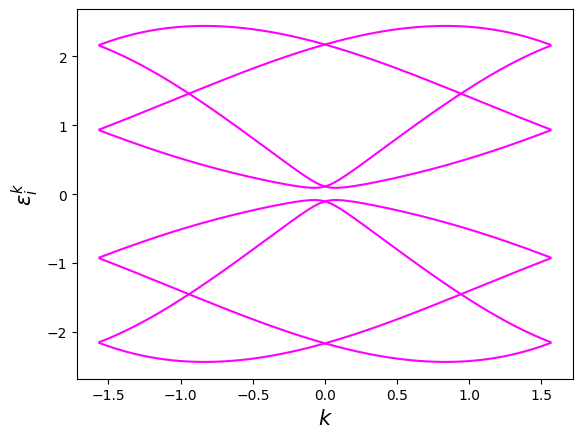

In [63]:
csfont = {'fontname':'Serif'}
#for i in range(4):
#    plt.scatter(k_range,lista1[:,i],c='magenta')
#    plt.scatter(k_range,-lista2[:,i],c='magenta')
plt.plot(k_range,lista1,c='magenta')
plt.plot(k_range,-lista2,c='magenta')
plt.plot(k_range1,lista3,c='magenta')
plt.plot(k_range1,-lista4,c='magenta')
plt.xlabel(r'$k$',**csfont, size='15')
plt.ylabel(r'$\epsilon_{i}^k$',**csfont, size='15')
#plt.title(r"$\alpha=$"+str(A)+r"$, \gamma=$"+str(G)+r"$, \theta=0$, t=1",**csfont, size = 15)
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/Dispersion Uf A="+str(A)+"G="+str(G)+"T="+str(T)+", ta="+str(t)+".pdf", bbox_inches='tight')  